In [2]:
from __future__ import print_function
from builtins import input
from builtins import range

import numpy as np

from sporco.admm import bpdn
from sporco import util
from sporco import plot
plot.config_notebook_plotting()

In [119]:
N = 512      # Signal size
M = 4*N      # Dictionary size
L = 32       # Number of non-zero coefficients in generator
sigma = 0.5  # Noise level

In [81]:
# Construct random dictionary and random sparse coefficients
np.random.seed(12345)
D = np.random.randn(N, M)
x0 = np.zeros((M, 1))
si = np.random.permutation(list(range(0, M-1)))
x0[si[0:L]] = np.random.randn(L, 1)

# Construct reference and noisy signal
s0 = D.dot(x0)
s = s0 + sigma*np.random.randn(N,1)

In [86]:
D.shape

(512, 2048)

In [89]:
s.shape

(512, 1)

In [88]:
x0.shape

(2048, 1)

In [82]:
opt = bpdn.BPDN.Options({'Verbose': False, 
                         'MaxMainIter': 500,
                         'RelStopTol': 1e-3, 
                         'AutoRho': {'RsdlTarget': 1.0},
                         #'NonNegCoef': True
                        })

In [83]:
# Function computing reconstruction error at lmbda
def evalerr(prm):
    lmbda = prm[0]
    b = bpdn.BPDN(D, s, lmbda, opt)
    x = b.solve()
    return np.sum(np.abs(x-x0))


# Parallel evalution of error function on lmbda grid
lrng = np.logspace(1, 2, 20)
sprm, sfvl, fvmx, sidx = util.grid_search(evalerr, (lrng,))
lmbda = sprm[0]

print('Minimum ℓ1 error: %5.2f at 𝜆 = %.2e' % (sfvl, lmbda))

Minimum ℓ1 error:  2.69 at 𝜆 = 2.98e+01


In [84]:
# Initialise and run BPDN object for best lmbda
b = bpdn.BPDN(D, s, lmbda, opt)
x = b.solve()

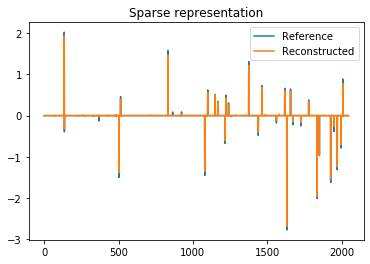

In [85]:
plot.plot(np.hstack((x0, x)), title='Sparse representation',
          lgnd=['Reference', 'Reconstructed'])

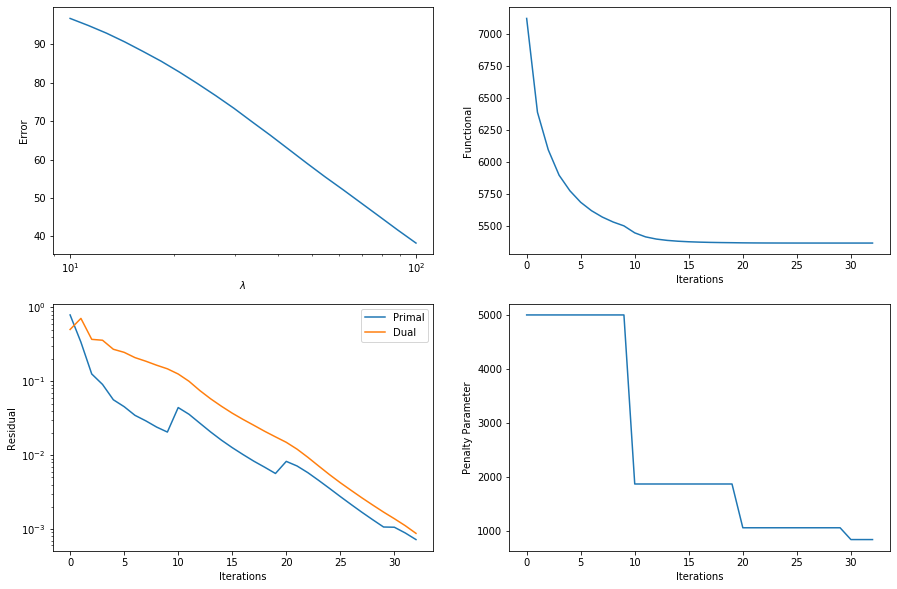

In [17]:
its = b.getitstat()
fig = plot.figure(figsize=(15, 10))
plot.subplot(2, 2, 1)
plot.plot(fvmx, x=lrng, ptyp='semilogx', xlbl='$\lambda$',
          ylbl='Error', fig=fig)
plot.subplot(2, 2, 2)
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional', fig=fig)
plot.subplot(2, 2, 3)
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'], fig=fig)
plot.subplot(2, 2, 4)
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter', fig=fig)
fig.show()

#### Estimating a Q-matrix with one concept per question

|  |C1|C2|C3|
|--|--|--|--|
|Q1|1 |0 |0 |
|Q2|1 |0 |0 |
|Q3|0 |1 |0 |
|Q4|0 |1 |0 |
|Q5|0 |0 |1 |

In [290]:
def create_q_matrix(n_questions, n_concepts, max_per_question=3):
    q_matrix = np.zeros((n_questions, n_concepts))
    for q in range(n_questions):
        n_c_question = np.random.randint(max_per_question)+1
        concepts = list(range(n_concepts))
        np.random.shuffle(concepts)
        q_matrix[q,concepts[:n_c_question]] = 1
    return q_matrix

D = create_q_matrix(10, 3, max_per_question=3)
D

array([[1., 0., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [0., 1., 0.],
       [1., 1., 0.],
       [1., 1., 1.],
       [1., 0., 1.],
       [0., 0., 1.],
       [0., 1., 1.],
       [1., 1., 1.]])

In [291]:
opt = bpdn.BPDN.Options({
#                          'Verbose': False, 
#                          'MaxMainIter': 500,
#                          'RelStopTol': 1e-3, 
#                          'AutoRho': {'RsdlTarget': 1.0},
                         'NonNegCoef': True
                        })

In [292]:
sigma = 0.1  # Noise level
# D = np.asarray([[1,0,0], [1,0,0], [0,1,0], [0,1,0], [0,0,1]])
x0 = np.eye(D.shape[1])

# Construct reference and noisy signal
# Normalize rows to sum one
row_sums = D.sum(axis=1, keepdims=True)
D_norm = D / row_sums
s0 = D.dot(x0)
s = s0 + sigma*np.random.randn(s0.shape[0], s0.shape[1])
# Normalize rows to sum one
row_sums = s.sum(axis=1, keepdims=True)
s_norm = s / row_sums
# s = s0 + sigma*np.random.randn(s0.shape[0], s0.shape[1])

In [293]:
# Function computing reconstruction error at lmbda
def evalerr(prm):
    lmbda = prm[0]
    b = bpdn.BPDN(D, s, lmbda, opt)
    x = b.solve()
    return np.sum(np.abs(x-x0))


# Parallel evalution of error function on lmbda grid
lrng = np.asarray([0.001, 0.01, 0.1, 1, 10, 100])
sprm, sfvl, fvmx, sidx = util.grid_search(evalerr, (lrng,))
lmbda = sprm[0]

print('Minimum ℓ1 error: %5.2f at 𝜆 = %.2e' % (sfvl, lmbda))

Minimum ℓ1 error:  0.33 at 𝜆 = 1.00e-01


In [294]:
sprm, sfvl, fvmx, sidx

(array([0.1]),
 0.3304849856208062,
 array([0.34477059, 0.34410442, 0.33048499, 0.42930584, 3.        ,
        3.        ]),
 (2,))

In [299]:
# Initialise and run BPDN object for best lmbda
b = bpdn.BPDN(D, s, lmbda, opt)
x = b.solve()
print(np.sum(np.abs(x-x0)))
x

0.3304849856208062


array([[0.89279091, 0.        , 0.        ],
       [0.        , 1.02948944, 0.05564554],
       [0.09193823, 0.02151962, 0.97531694]])

In [303]:
# Function computing reconstruction error at lmbda
def evalerr(prm):
    lmbda = prm[0]
    b = bpdn.BPDN(D_norm, s_norm, lmbda, opt)
    x = b.solve()
    return np.sum(np.abs(x-x0))


# Parallel evalution of error function on lmbda grid
lrng = np.asarray([0.001, 0.01, 0.1, 1, 10, 100])
sprm, sfvl, fvmx, sidx = util.grid_search(evalerr, (lrng,))
lmbda = sprm[0]

print('Minimum ℓ1 error: %5.2f at 𝜆 = %.2e' % (sfvl, lmbda))

Minimum ℓ1 error:  0.43 at 𝜆 = 1.00e-02


In [304]:
# Initialise and run BPDN object for best lmbda
b = bpdn.BPDN(D_norm, s_norm, lmbda, opt)
x = b.solve()
print(np.sum(np.abs(x-x0)))
x

0.43341399861516194


array([[0.88063828, 0.01496888, 0.07024859],
       [0.        , 1.00444863, 0.01838612],
       [0.1003333 , 0.        , 0.89433323]])